Lecture: AI I - Basics 

Previous:
[**Chapter 3.6: Additional Libraries and Tools**](../03_data/06_additionals.ipynb)

---

# Chapter 4.1: Data Preparation with scikit-learn

- [Imputation](#imputation)
- [Scaling](#scaling)
- [Dimensionality Reduction](#dimensionality-reduction)
- [Pipelines](#pipelines)
- [Feature Union](#feature-union)
- [Column Transformations](#column-transformations)

__Scikit-learn__ (also known as __sklearn__) is an open-source software library for machine learning in Python. It is very popular and actively maintained. The library offers various classification, regression, and clustering algorithms. In addition, sklearn also includes algorithms for model selection, dimensionality reduction, and data preprocessing.  

In this notebook, we (again) focus on data preprocessing (Data Preparation) and cover the following topics:
- Imputation  
- Scaling  
- Dimensionality Reduction  
- Pipelines  
- Feature Union  
- Column Transformations  

The documentation for scikit-learn can be found [here](https://scikit-learn.org/stable/index.html).  


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Imputation

Imputation refers to the completion of missing values (NaNs). As in pandas, there are various methods in sklearn to replace missing values. More information can be found [here](https://scikit-learn.org/stable/modules/impute.html).  


In [3]:
nan_data = np.array([[1, 2], [np.nan, 3], [7, 6]])

### One-dimensional Imputation

In one-dimensional imputation, the values are replaced column by column. The class [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) provides basic strategies for this purpose. Missing values can be replaced with a given constant value or with statistical values (mean, median, or most frequent value) of each column containing the missing values. This class also allows for different encodings of missing values.  


In [4]:
from sklearn.impute import SimpleImputer

# define different imputer
mean_imputer = SimpleImputer()
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

In [5]:
# First the imputer has to be fitted to the data, so either call first fit and then transform 
# or call fit_transform to do it in one step
mean_imputer.fit(nan_data)
mean_imputer.transform(nan_data)

array([[1., 2.],
       [4., 3.],
       [7., 6.]])

In [6]:
zero_imputer.fit_transform(nan_data)

array([[1., 2.],
       [0., 3.],
       [7., 6.]])

In [7]:
different_nan_data = np.array([[np.nan, 5], [8, 2], [6, 6]])
mean_imputer.transform(different_nan_data)

array([[4., 5.],
       [8., 2.],
       [6., 6.]])

__Brainstorming:__  
<details>
<summary>Why was np.nan replaced with 4?</summary>
Because the mean_imputer was previously "trained" on the other data.  
</details>

<details>
<summary>When can this behavior be an advantage?</summary>
An advantage is that the imputation strategies or exact values used during training can also be applied at test time or in live operation.  
</details>


In [8]:
zero_imputer.transform(different_nan_data)

array([[0., 5.],
       [8., 2.],
       [6., 6.]])

It is also possible to replace values other than `np.nan`.  


In [9]:
fischers_fritz = [
    ['Fischers', '', 'fischt', 'frische', 'Fische'],
    ['Frische', 'Fische', 'fischt', 'Fischers', '']
]

string_imputer = SimpleImputer(missing_values='', strategy='constant', fill_value='Fritz')
string_imputer.fit_transform(fischers_fritz)          

array([['Fischers', 'Fritz', 'fischt', 'frische', 'Fische'],
       ['Frische', 'Fische', 'fischt', 'Fischers', 'Fritz']], dtype=object)

### Multidimensional Variant
The multidimensional variant is significantly more complex. Roughly summarized, each missing value is modeled as a function of other features, and this estimate is then used for imputation. This process is repeated several times before the final replacements are made. This behavior is implemented by the [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).  

> __Note:__ This class is still experimental.  


In [10]:
from sklearn.experimental import enable_iterative_imputer  

from sklearn.impute import IterativeImputer

First, we create a small dummy dataset where the values of the individual columns have a clear relationship to each other.  


In [11]:
x = np.arange(1, 11, dtype="float")
y = x * x 

data = np.array([x, y])
data[(0, 1)] = np.nan
data[(0, 6)] = np.nan
data[(1, 3)] = np.nan
data[(1, 9)] = np.nan
data = data.T
data

array([[ 1.,  1.],
       [nan,  4.],
       [ 3.,  9.],
       [ 4., nan],
       [ 5., 25.],
       [ 6., 36.],
       [nan, 49.],
       [ 8., 64.],
       [ 9., 81.],
       [10., nan]])

Afterwards, we can again use `fit_transform` to replace the data.  


In [12]:
IterativeImputer().fit_transform(data)

array([[ 1.        ,  1.        ],
       [ 2.3175117 ,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.35578423],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.58808359, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.09539114]])

The replacements of the `SimpleImputer`, on the other hand, look as follows.  


In [13]:
SimpleImputer().fit_transform(data)

array([[ 1.   ,  1.   ],
       [ 5.75 ,  4.   ],
       [ 3.   ,  9.   ],
       [ 4.   , 33.625],
       [ 5.   , 25.   ],
       [ 6.   , 36.   ],
       [ 5.75 , 49.   ],
       [ 8.   , 64.   ],
       [ 9.   , 81.   ],
       [10.   , 33.625]])

__Brainstorming:__  
<details>
    <summary>What are the advantages of the multidimensional variant?</summary>
    A major advantage is that the missing data is replaced depending on other data. This is often better, as there may be dependencies between the data. Example: height and weight of individuals.
</details>


In the following three lines of code, the iterative working method of the algorithm becomes visible.  


In [14]:
IterativeImputer(max_iter=1).fit_transform(data)

/workspaces/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[ 1.        ,  1.        ],
       [ 3.10315829,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 20.73213454],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.8956479 , 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 82.62527756]])

In [15]:
IterativeImputer(max_iter=2).fit_transform(data)

/workspaces/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[ 1.        ,  1.        ],
       [ 2.34645245,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.28201783],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.61040064, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.06934333]])

In [16]:
IterativeImputer(max_iter=3).fit_transform(data)

array([[ 1.        ,  1.        ],
       [ 2.3175117 ,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.35578423],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.58808359, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.09539114]])

## Scaling

### Standardization
Standardization refers to a transformation of the input data such that the resulting data has a mean of 0 and a variance of 1. The resulting data is therefore normally distributed. This is particularly helpful when all variables are scaled differently.  

__Example:__ A dataset contains the values height in meters and weight in kilograms of people. The variance of the variables will clearly differ, since height is on a scale from 0.1 m to 2.8 m, while weight is on a scale from 0.5 kg to 600 kg.  

In sklearn, the class [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) is used for standardization.  


In [17]:
from sklearn.preprocessing import StandardScaler

scaling_data = np.array([
    [1.79, 79.5], 
    [1.60, 53.2], 
    [2.59, 150], 
    [1.73, 70.7], 
    [1.50, 46.7], 
    [1.75, 113.0], 
    [1.93, 247.2]
])
print(f"Mittelwerte pro Feature: {scaling_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {scaling_data.std(axis=0)}")

Mittelwerte pro Feature: [  1.84142857 108.61428571]
Standardabweichung pro Feature: [ 0.33090476 65.60408151]


In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaling_data)
scaled_data

array([[-0.15541805, -0.44378772],
       [-0.72960139, -0.84467741],
       [ 2.26219602,  0.63084054],
       [-0.3367391 , -0.57792572],
       [-1.03180315, -0.94375661],
       [-0.27629875,  0.06685124],
       [ 0.26766441,  2.11245568]])

In [19]:
print(f"Mittelwerte pro Feature: {scaled_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {scaled_data.std(axis=0)}")

Mittelwerte pro Feature: [-3.17206578e-17  6.34413157e-17]
Standardabweichung pro Feature: [1. 1.]


__Brainstorming:__  
<details>
<summary>Why isn’t the mean at 0?</summary>
These are calculation errors that can be neglected. e-17 is an extremely small number.
</details>


If the data should not be centered, this can be prevented with the parameter `with_mean=False`.  


In [20]:
not_center_scaler = StandardScaler(with_mean=False)
non_centric_data = not_center_scaler.fit_transform(scaling_data)

print(f"Mittelwerte pro Feature: {non_centric_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {non_centric_data.std(axis=0)}")
non_centric_data

Mittelwerte pro Feature: [5.56482953 1.65560257]
Standardabweichung pro Feature: [1. 1.]


array([[5.40941148, 1.21181485],
       [4.83522814, 0.81092516],
       [7.82702555, 2.28644311],
       [5.22809043, 1.07767685],
       [4.53302638, 0.71184595],
       [5.28853078, 1.72245381],
       [5.83249394, 3.76805824]])

It is also possible not to scale the data in order to preserve the variance. For this, the constructor must be called with the parameter `with_std=False`.  


In [21]:
not_scaling_scaler = StandardScaler(with_std=False)
non_scaled_data = not_scaling_scaler.fit_transform(scaling_data)

print(f"Mittelwerte pro Feature: {non_scaled_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {non_scaled_data.std(axis=0)}")
non_scaled_data

Mittelwerte pro Feature: [0. 0.]
Standardabweichung pro Feature: [ 0.33090476 65.60408151]


array([[-5.14285714e-02, -2.91142857e+01],
       [-2.41428571e-01, -5.54142857e+01],
       [ 7.48571429e-01,  4.13857143e+01],
       [-1.11428571e-01, -3.79142857e+01],
       [-3.41428571e-01, -6.19142857e+01],
       [-9.14285714e-02,  4.38571429e+00],
       [ 8.85714286e-02,  1.38585714e+02]])

### Scaling features to a specific range

Alternatively, features can be scaled so that they lie between a given minimum and maximum value, often between zero and one, or such that the maximum absolute value of each feature is scaled to unit size. This can be achieved with [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#) or [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#).  


In [22]:
from sklearn.preprocessing import MinMaxScaler
min_max_data = np.array([
    [-1, 2], 
    [-0.5, 6], 
    [0, 10], 
    [1, 18]
])

zero_one_scaler = MinMaxScaler()
zero_one_scaler.fit_transform(min_max_data)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

To change the range, the parameter `feature_range` can be specified in the constructor.  


In [23]:
minus_one_one_scaler = MinMaxScaler(feature_range=(-1, 1))
minus_one_one_scaler.fit_transform(min_max_data)

array([[-1. , -1. ],
       [-0.5, -0.5],
       [ 0. ,  0. ],
       [ 1. ,  1. ]])

In [24]:
from sklearn.preprocessing import MaxAbsScaler
max_abs_data = np.array([
    [ 1., -1.,  2.],
    [ 2.,  0.,  0.],
    [ 0.,  1., -1.]
])

max_abs_scaler = MaxAbsScaler()
max_abs_scaler.fit_transform(max_abs_data)

array([[ 0.5, -1. ,  1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. , -0.5]])

### Problems with Outliers
The three previously introduced classes are not particularly good at handling outliers during scaling. This problem is illustrated [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).  

A scaler that works with outliers is the [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).  


In [25]:
from sklearn.preprocessing import RobustScaler
outlier_data = np.array([
    [2, 4, 1, 27, 3, 4, 1, 3, 3, 2],
    [100, 92, 87, 94, 95, 83, 177, 84, 99, 89]
]).T

robust_scaler = RobustScaler(quantile_range=(25, 75))
robust_scaler.fit_transform(outlier_data)

array([[-0.57142857,  0.66666667],
       [ 0.57142857, -0.0952381 ],
       [-1.14285714, -0.57142857],
       [13.71428571,  0.0952381 ],
       [ 0.        ,  0.19047619],
       [ 0.57142857, -0.95238095],
       [-1.14285714,  8.        ],
       [ 0.        , -0.85714286],
       [ 0.        ,  0.57142857],
       [-0.57142857, -0.38095238]])

In [26]:
robust_scaler.scale_

array([ 1.75, 10.5 ])

In [27]:
robust_scaler.center_

array([ 3., 93.])

In comparison, the StandardScaler would scale the data as follows.  


In [28]:
StandardScaler().fit_transform(outlier_data)

array([[-0.40525742,  0.        ],
       [-0.13508581, -0.30477573],
       [-0.54034323, -0.49526056],
       [ 2.97188775, -0.2285818 ],
       [-0.27017161, -0.19048483],
       [-0.13508581, -0.64764842],
       [-0.54034323,  2.93346637],
       [-0.27017161, -0.60955145],
       [-0.27017161, -0.03809697],
       [-0.40525742, -0.41906662]])

__Exercise:__  
<details>
<summary>How are the new values calculated?</summary>
First, the median and the quantiles per column must be determined. Then the new values can be calculated as follows:  

$$x_{new} = \frac{x_{old} - median}{quantile_{upper} - quantile_{lower}}$$
</details>


## Dimensionality Reduction
Dimensionality reduction refers to the reduction of the number of random variables. This can be helpful both for visualization and for machine learning.  

In the following, we will use the Iris dataset (Iris = sword lily). It consists of 4 features (sepal length, sepal width, petal length, and petal width) and has 3 classes.  


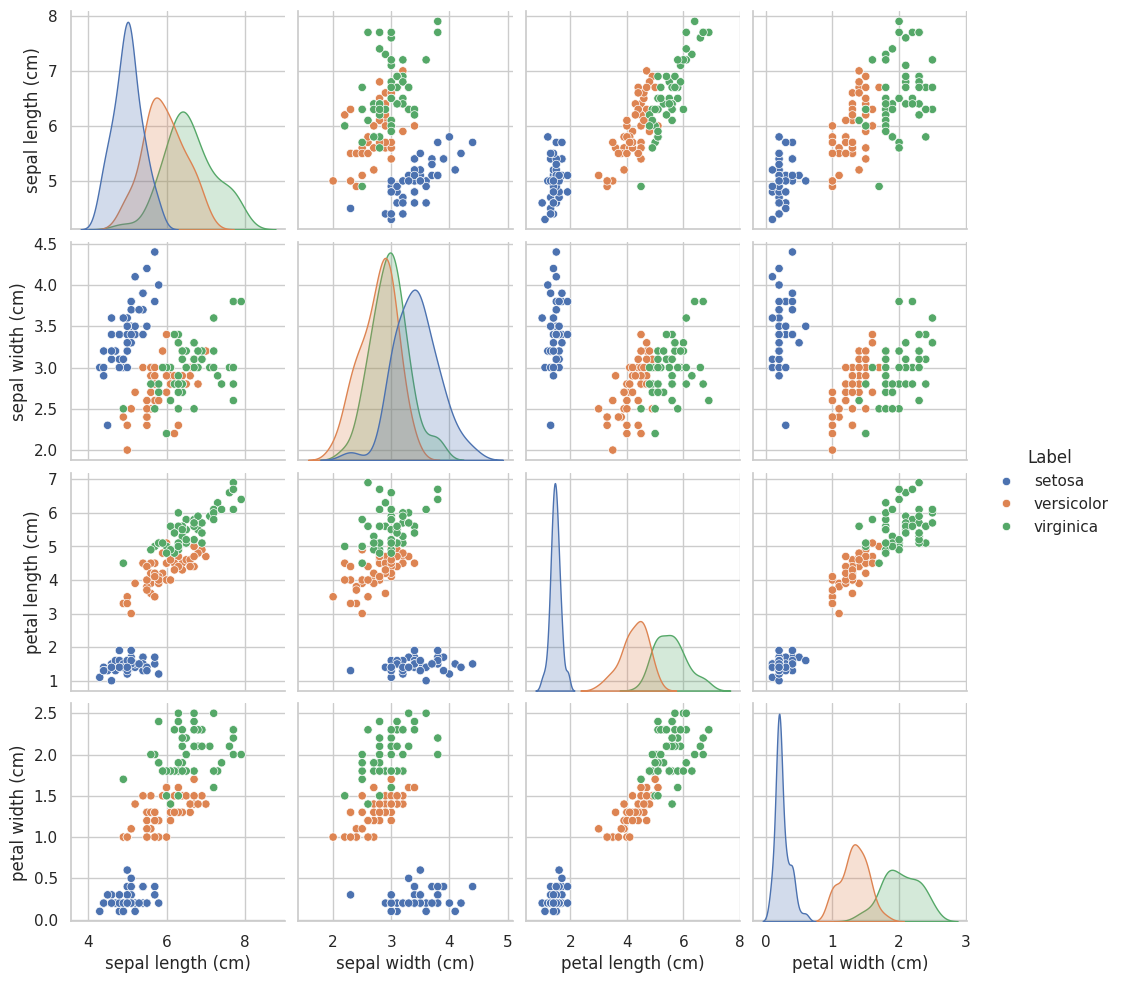

In [29]:
iris = datasets.load_iris(as_frame=True)
iris_df = iris.frame
iris_df['Label'] = iris.target_names[iris_df['target']]
iris_df = iris_df.drop('target', axis=1)

sns.set_theme(style="whitegrid")
sns.pairplot(iris_df, hue="Label")

### Principal Component Analysis (PCA)

PCA is used to decompose a multidimensional dataset into a set of successive orthogonal components that explain the maximum proportion of variance. Like the previous algorithms, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is implemented as a transformer object. This means it must first be trained with `fit()`. Afterwards, it can be applied to the data to find the $n$ features that explain the largest proportion of variance in the data.  


Text(0, 0.5, 'Dimension 2')

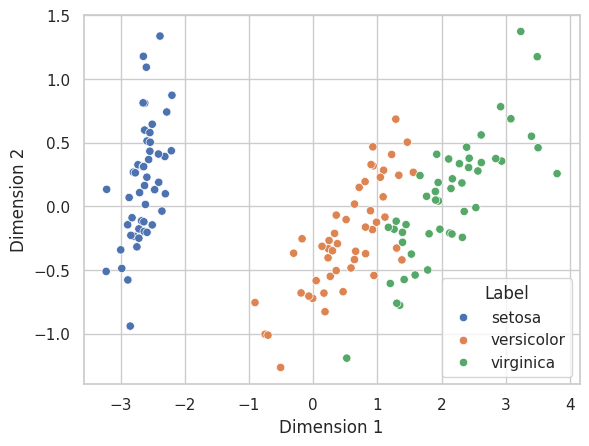

In [30]:
from sklearn.decomposition import PCA

# we want to have the two components with the highest variance
pca = PCA(n_components=2)
pca.fit(iris.data)
reduced_iris = pca.transform(iris.data)

# show the two components with the highest variance
ax_pca = sns.scatterplot(x=reduced_iris[:, 0], y=reduced_iris[:, 1], hue=iris_df['Label'])
ax_pca.set_xlabel('Dimension 1')
ax_pca.set_ylabel('Dimension 2')

__Brainstorming:__  
<details>
<summary>What could be a weakness of PCA in the context of a classification task?</summary>
PCA tries to find the greatest variance in the entirety of the data. However, PCA does not take into account the variance between the individual classes. This can lead to suboptimal features being selected for classification.  
</details>


### Linear Discriminant Analysis (LDA)

[Linear Discriminant Analysis (LDA)]() uses class membership in contrast to PCA. It attempts to determine the features that have the greatest influence on the variance between the classes. Since LDA makes use of class membership, it is a supervised method.  


Text(0, 0.5, 'Dimension 2')

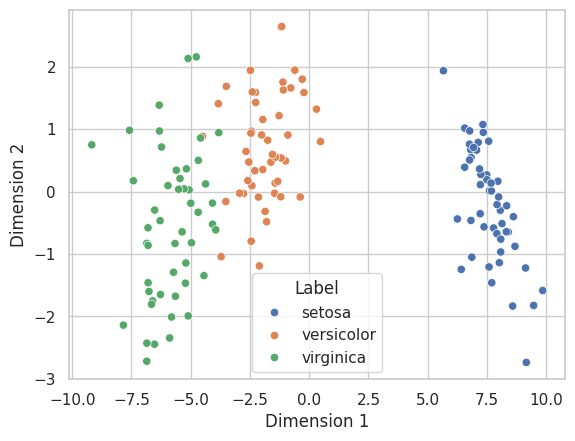

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris.data, iris.target)
lda_reduced_iris = lda.transform(iris.data)

# show the two components with the highest variance between classes
ax_lda = sns.scatterplot(x=lda_reduced_iris[:, 0], y=lda_reduced_iris[:, 1], hue=iris_df['Label'])
ax_lda.set_xlabel('Dimension 1')
ax_lda.set_ylabel('Dimension 2')

### Comparison of PCA and LDA


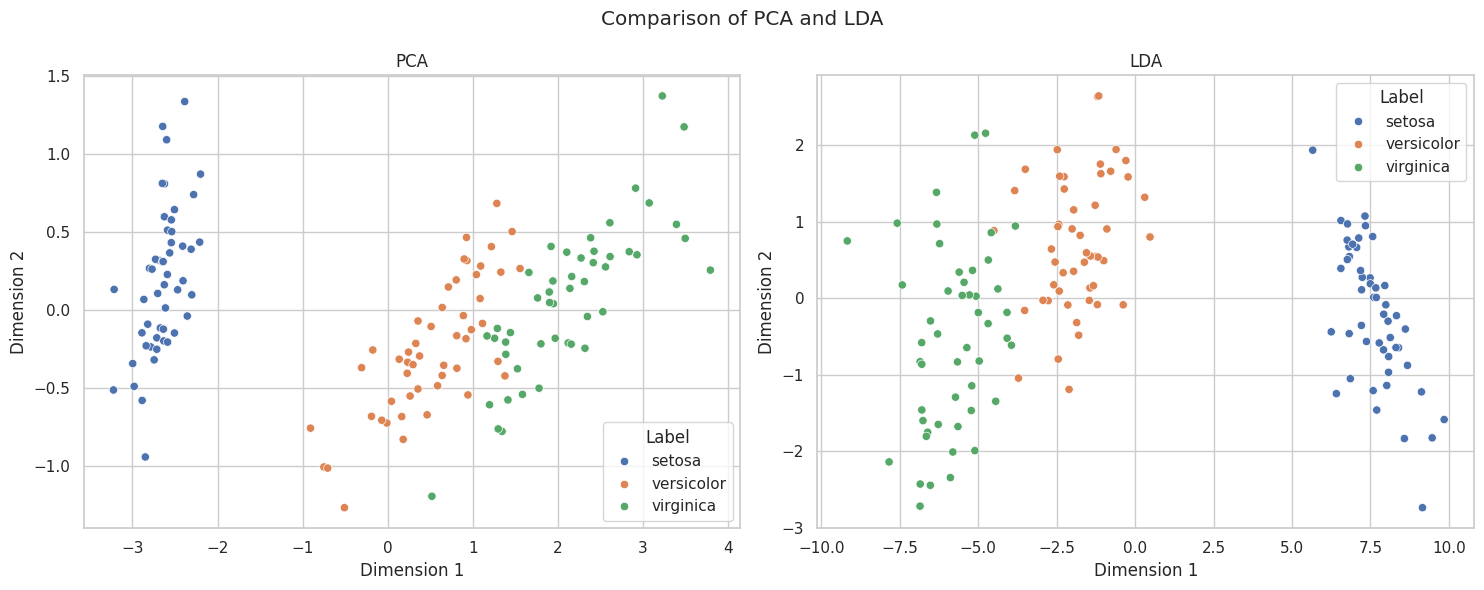

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.scatterplot(x=reduced_iris[:, 0], y=reduced_iris[:, 1], hue=iris_df['Label'], ax=ax1)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_title('PCA')

sns.scatterplot(x=lda_reduced_iris[:, 0], y=lda_reduced_iris[:, 1], hue=iris_df['Label'], ax=ax2)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_title('LDA')

fig.suptitle('Comparison of PCA and LDA')
fig.tight_layout()

## Pipelines
[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) can be used to chain multiple estimators into one. This is useful because there is often a fixed sequence of steps in data processing, such as feature selection, normalization, and classification. Pipelines serve several purposes here:

1) __Convenience and encapsulation__  
> You only need to call `fit` and `predict` once on your data to fit an entire sequence of estimators.

2) __Joint parameter selection__  
> You can perform a grid search over the parameters of all estimators in the pipeline at once. We will cover this in more detail later.

3) __Safety__  
> Pipelines help prevent statistics from leaking from your test data into the trained model during cross-validation (we will also cover this later) by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e., they must have a `transform` method). The last estimator can be of any type (transformer, classifier, etc.).  


### Constructor
The [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is built with a list of (key, value) pairs, where the key is a string containing the name you want to assign to this step, and the value is an estimator.  


In [33]:
from sklearn.pipeline import Pipeline

# first, create a dictionary with all the estimators we want to have in the pipeline, each step needs a name
estimators = [('imputer', SimpleImputer()), ('scaler', StandardScaler())]

# then, pass the estimators to the Pipeline constructor
pipe = Pipeline(estimators)
pipe

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [34]:
# if you don't want to name the estimators explicit you can use the make_pipeline function
from sklearn.pipeline import make_pipeline
make_pipeline(SimpleImputer(), StandardScaler())

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


### Setting parameters of estimators
The parameters of the estimators in the pipeline can be accessed using the syntax `<estimator>__<parameter>` (_2 underscores_).  


In [35]:
pipe.set_params(imputer__strategy='constant', imputer__fill_value=0)

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,0
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


After setting the parameters, we can test the pipeline with dummy values.  


In [36]:
pipe_data = [[1, 4], [5, 8], [np.nan, 5], [3, np.nan]]
pipe.fit_transform(pipe_data)

array([[-0.65094455, -0.08737041],
       [ 1.43207802,  1.31055608],
       [-1.1717002 ,  0.26211122],
       [ 0.39056673, -1.4852969 ]])

To use different parameters, they must again be set with `set_params()`.  


In [37]:
# reset to default parameters
pipe.set_params(imputer__strategy='mean', imputer__fill_value=None)

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [38]:
pipe.fit_transform(pipe_data)

array([[-1.41421356, -1.13227703],
       [ 1.41421356,  1.58518785],
       [ 0.        , -0.45291081],
       [ 0.        ,  0.        ]])

It is also possible to completely replace individual steps. For this, `set_params()` is also used, specifying the name of the step that should be replaced.  


In [39]:
pipe.set_params(scaler=MaxAbsScaler())

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [40]:
pipe.fit_transform(pipe_data)

array([[0.2       , 0.5       ],
       [1.        , 1.        ],
       [0.6       , 0.625     ],
       [0.6       , 0.70833333]])

If a step in the pipeline should no longer be executed, this can be achieved by passing the value `'passthrough'`.  


In [41]:
pipe.set_params(imputer='passthrough')

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True


In [42]:
pipe.fit_transform(pipe_data)

array([[0.2  , 0.5  ],
       [1.   , 1.   ],
       [  nan, 0.625],
       [0.6  ,   nan]])

## Feature Union
[FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) combines multiple transformer objects into a new transformer that merges their outputs. A FeatureUnion takes a list of transformer objects. During fitting, each of them is independently fitted to the data. The transformers are applied in parallel, and the feature matrices they output are concatenated side by side into a larger matrix.  


### Constructor
A FeatureUnion is built from a list of (key, value) pairs, where the key is the name you want to assign to a given transformation and the value is an estimator.  


In [43]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import KernelPCA

estimators = [('linear_pca', PCA()), ('kernel_pca', KernelPCA())]
combined = FeatureUnion(estimators)
combined

,transformer_list,"[('linear_pca', ...), ('kernel_pca', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'


Here as well, it is possible not to explicitly name the steps. For this, the method `make_union()` can be used.  


In [44]:
from sklearn.pipeline import make_union
make_union(PCA(), KernelPCA())

,transformer_list,"[('pca', ...), ('kernelpca', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'


In [45]:
combined_data = [[1, 4, 3], [5, 8, 7], [2, 5, 4], [3, 6, 5]]
combined.fit_transform(combined_data)

array([[-3.03108891e+00,  3.94905005e-16, -1.17971589e-33,
        -3.03108891e+00],
       [ 3.89711432e+00,  2.95086548e-16,  2.80637082e-33,
         3.89711432e+00],
       [-1.29903811e+00, -2.72320720e-17,  1.00842777e-32,
        -1.29903811e+00],
       [ 4.33012702e-01,  2.68598850e-17, -3.26251546e-33,
         4.33012702e-01]])

### Setting transformer parameters
Here too, the parameters of the transformers can be set using the `set_params()` method.  


In [46]:
combined.set_params(linear_pca__n_components=3)

,transformer_list,"[('linear_pca', ...), ('kernel_pca', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'


To ignore a step, the value `'drop'` must be assigned to the corresponding step name.  


In [47]:
combined.set_params(kernel_pca='drop')

,transformer_list,"[('linear_pca', ...), ('kernel_pca', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'


## Column Transformations
Many datasets contain features of different types, e.g., text, floating-point numbers, and dates, where each feature type requires separate preprocessing or feature extraction steps. Often, it is easiest to preprocess the data before applying scikit-learn methods, for example with __Pandas__.  

However, preprocessing the data before passing it to scikit-learn can be problematic for one of the following reasons:  
1) Including statistics from test data in the preprocessors makes cross-validation results unreliable (known as data leakage), for example in the case of scalers or imputation of missing values.  

2) You may want to include preprocessing parameters in a parameter search.  

The [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) helps perform different transformations for different columns of the data, within a pipeline that is safe from data leakage and can be parameterized.  

### Creating dummy data
First, we create a dataset that contains both numeric data and text.  


In [48]:
book_data_raw = pd.DataFrame(
    {
        'city': ['London', 'London', 'Paris', 'Sallisaw'],
        'title': ["His Last Bow", "How Watson Learned the Trick", "A Moveable Feast", "The Grapes of Wrath"],
        'expert_rating': [5, 3, 4, 5],
        'user_rating': [4, 5, 4, 3]
    }
)

__Brainstorming:__  

<details>
<summary>How can we use the text data?</summary>
To use text data for machine learning, it must be converted into numbers. In this case, the city can, for example, be one-hot encoded, and for the title we can count the occurring words (we will go into more detail on this in the seminar).
</details>


### Constructor
We want to apply the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) to the `'city'` column and the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to the `'title'` column.  


In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer([
    ('city_category', OneHotEncoder(dtype='int'), ['city']),
    ('title_bow', CountVectorizer(), 'title')
])

column_trans.fit(book_data_raw) 

,transformers,"[('city_category', ...), ('title_bow', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


The names of the features can be obtained using the `get_feature_names()` method.  


In [50]:
column_trans.get_feature_names_out()

array(['city_category__city_London', 'city_category__city_Paris',
       'city_category__city_Sallisaw', 'title_bow__bow',
       'title_bow__feast', 'title_bow__grapes', 'title_bow__his',
       'title_bow__how', 'title_bow__last', 'title_bow__learned',
       'title_bow__moveable', 'title_bow__of', 'title_bow__the',
       'title_bow__trick', 'title_bow__watson', 'title_bow__wrath'],
      dtype=object)

In [51]:
column_trans.transform(book_data_raw).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

All features that were not passed to a transformer are, by default, not included in the output. To change this behavior, a value for the parameter `remainder` can be passed to the constructor.  


In [52]:
column_trans = ColumnTransformer([
    ('city_category', OneHotEncoder(dtype='int'), ['city']),
    ('title_bow', CountVectorizer(), 'title')
], remainder='passthrough')

column_trans.fit(book_data_raw)

,transformers,"[('city_category', ...), ('title_bow', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [53]:
column_trans.get_feature_names_out()

array(['city_category__city_London', 'city_category__city_Paris',
       'city_category__city_Sallisaw', 'title_bow__bow',
       'title_bow__feast', 'title_bow__grapes', 'title_bow__his',
       'title_bow__how', 'title_bow__last', 'title_bow__learned',
       'title_bow__moveable', 'title_bow__of', 'title_bow__the',
       'title_bow__trick', 'title_bow__watson', 'title_bow__wrath',
       'remainder__expert_rating', 'remainder__user_rating'], dtype=object)

In [54]:
column_trans.transform(book_data_raw)

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 5],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 5, 3]])

Here too, there is the option not to explicitly assign names to the individual steps. For this, the method `make_column_transformer()` can be used. In addition, you can also pass a transformer to the `remainder` parameter. This transformer will then be applied to all remaining columns.  


In [55]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler()
)
column_trans

,transformers,"[('onehotencoder', ...), ('countvectorizer', ...)]"
,remainder,MinMaxScaler()
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [56]:
column_trans.fit_transform(book_data_raw)

array([[1. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 1. , 0.5],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 1. ,
        1. , 1. , 0. , 0. , 1. ],
       [0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. ,
        0. , 0. , 1. , 1. , 0. ]])

---

Lecture: AI I - Basics 

Exercise: [**Exercise 4.1: Data Preparation**](../04_ml/exercises/01_data_preparation.ipynb)

Next: [**Chapter 4.2: Machine Learning with scikit-learn**](../04_ml/02_machine_learning.ipynb)